<a href="https://colab.research.google.com/github/abhinavsagar/Breast-cancer-classification/blob/master/Breast_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Жүктеу және алдын-ала өңдеу

In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [2]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)[:2]):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('data/train/benign',112))
malign_train = np.array(Dataset_loader('data/train/malignant',112))
benign_test = np.array(Dataset_loader('data/validation/benign',112))
malign_test = np.array(Dataset_loader('data/validation/malignant',112))

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 62.60it/s]


# Белгі жасау

In [5]:
# Тері қатерлі ісігі: қатерлі және жақсы
# Белгілерді жасау
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Деректерді біріктіру
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Оқыту деректерін араластыру
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Тест деректерін араластыру
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# Категориялық
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Оқыту және бөлу

In [6]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Кейбір Суреттерді Көрсету

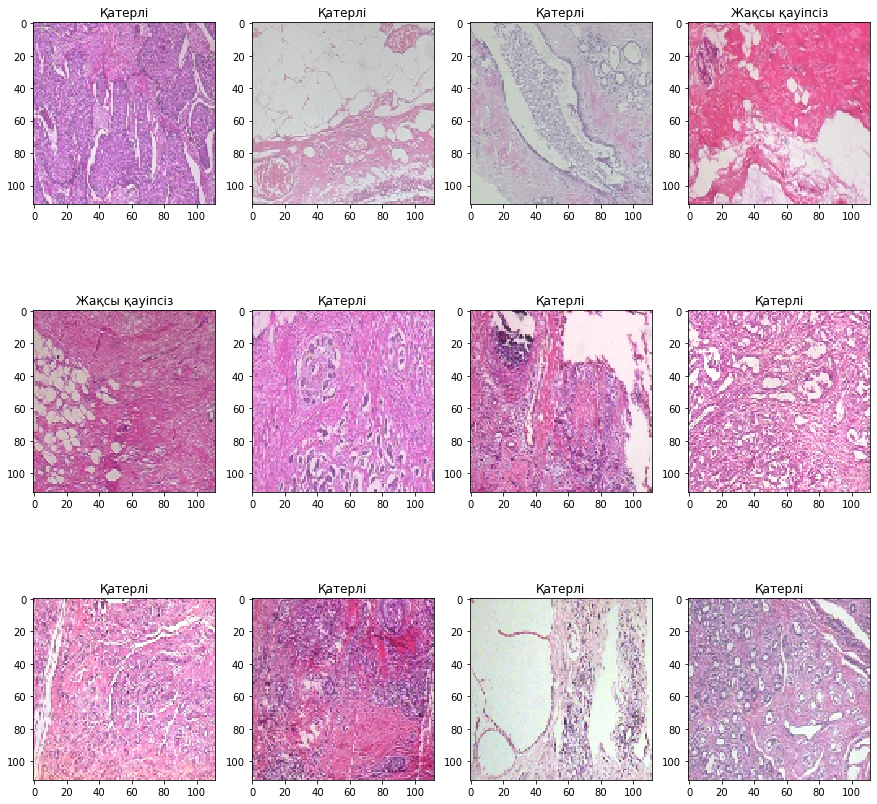

In [7]:
## Мольдердің алғашқы 15 суретін көрсету және олардың жіктелуі
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Қатерсіз')
    else:
        ax.title.set_text('Қатерлі')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Деректер генераторы

In [8]:
BATCH_SIZE = 16

# Бастапқы генераторды пайдалану
train_generator = ImageDataGenerator(
        zoom_range=2,  # кездейсоқ масштабтау үшін ауқымды орнату
        rotation_range = 90,
        horizontal_flip=True,  # суреттерді кездейсоқ бұру
        vertical_flip=True,  # суреттерді кездейсоқ бұру
    )

# Модель: ResNet50

In [9]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [10]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(112,112,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 3, 3, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1920)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


In [11]:
# Оқу Жылдамдығын Төмендету
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Бақылау нүктесі
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Оқыту және бағалау

In [12]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
52/51 [==============================] - 273s 5s/step - loss: 0.7253 - accuracy: 0.6196 - val_loss: 0.6740 - val_accuracy: 0.6923


c:\users\yelzha\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
c:\users\yelzha\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/20
52/51 [==============================] - 262s 5s/step - loss: 0.5324 - accuracy: 0.7415 - val_loss: 0.4878 - val_accuracy: 0.7596
Epoch 3/20
52/51 [==============================] - 264s 5s/step - loss: 0.5026 - accuracy: 0.7657 - val_loss: 0.4988 - val_accuracy: 0.7837
Epoch 4/20
52/51 [==============================] - 289s 6s/step - loss: 0.4127 - accuracy: 0.8068 - val_loss: 0.3390 - val_accuracy: 0.8269
Epoch 5/20
52/51 [==============================] - 281s 5s/step - loss: 0.4196 - accuracy: 0.8164 - val_loss: 0.3250 - val_accuracy: 0.8606
Epoch 6/20
52/51 [==============================] - 290s 6s/step - loss: 0.3498 - accuracy: 0.8539 - val_loss: 0.3260 - val_accuracy: 0.8798
Epoch 7/20
52/51 [==============================] - 288s 6s/step - loss: 0.3087 - accuracy: 0.8708 - val_loss: 0.2452 - val_accuracy: 0.8942
Epoch 8/20
52/51 [==============================] - 277s 5s/step - loss: 0.3227 - accuracy: 0.8599 - val_loss: 0.4639 - val_accuracy: 0.8221
Epoch 9/20
52

In [21]:
model.save_weights(filepath)

In [13]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<AxesSubplot:>

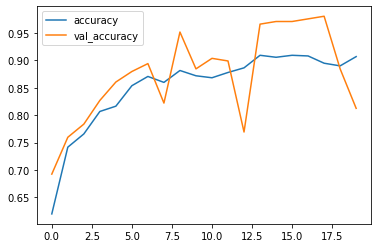

In [17]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

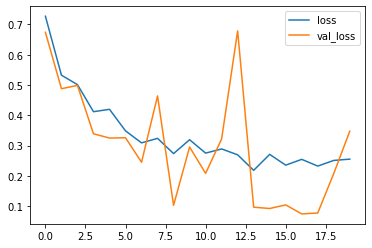

In [19]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Болжау

In [22]:
model.load_weights("weights.best.hdf5")

In [23]:
Y_val_pred = model.predict(x_val)

In [24]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.8125

In [25]:
Y_pred = model.predict(X_test)

In [26]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [15:01<00:00, 90.13s/it]


### Шатастыру матрицасы арқылу мәндерді көру

Шатастыру матрицасы, нормаланусыз келтірусіз
[[194  95]
 [151 519]]


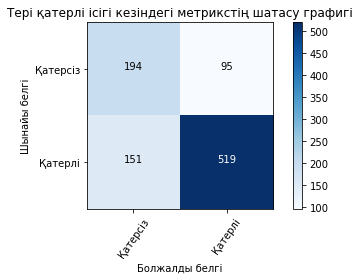

In [27]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Бұл функция шатасу матрицасын басып шығарады және жасайды.
    Нормализацияны 'normalize=True' орнату арқылы қолдануға болады.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Нормаланған шатастыру матрицасы")
    else:
        print('Шатастыру матрицасы, нормаланусыз келтірусіз')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Шынайы белгі')
    plt.xlabel('Болжалды белгі')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Қатерсіз', 'Қатерлі']
plot_confusion_matrix(cm, cm_plot_label, title ='Тері қатерлі ісігі кезіндегі метрикстің шатасу графигі')

Шатастыру матрицасы, нормаланусыз келтірусіз
[[137 152]
 [ 43 627]]


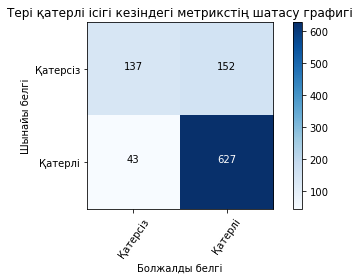

In [28]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['Қатерсіз', 'Қатерлі']
plot_confusion_matrix(cm, cm_plot_label, title ='Тері қатерлі ісігі кезіндегі метрикстің шатасу графигі')

### Жіктеу туралы есеп

In [32]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1)))

              precision    recall  f1-score   support

           0       0.76      0.47      0.58       289
           1       0.80      0.94      0.87       670

   micro avg       0.80      0.80      0.80       959
   macro avg       0.78      0.70      0.72       959
weighted avg       0.79      0.80      0.78       959



### ROC және AUC

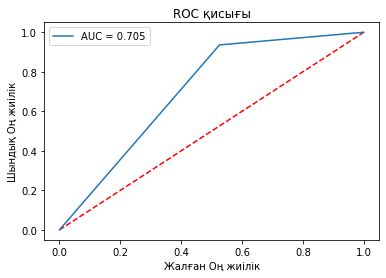

In [30]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('Жалған Оң жиілік')
plt.ylabel('Шындық Оң жиілік')
plt.title('ROC қисығы')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

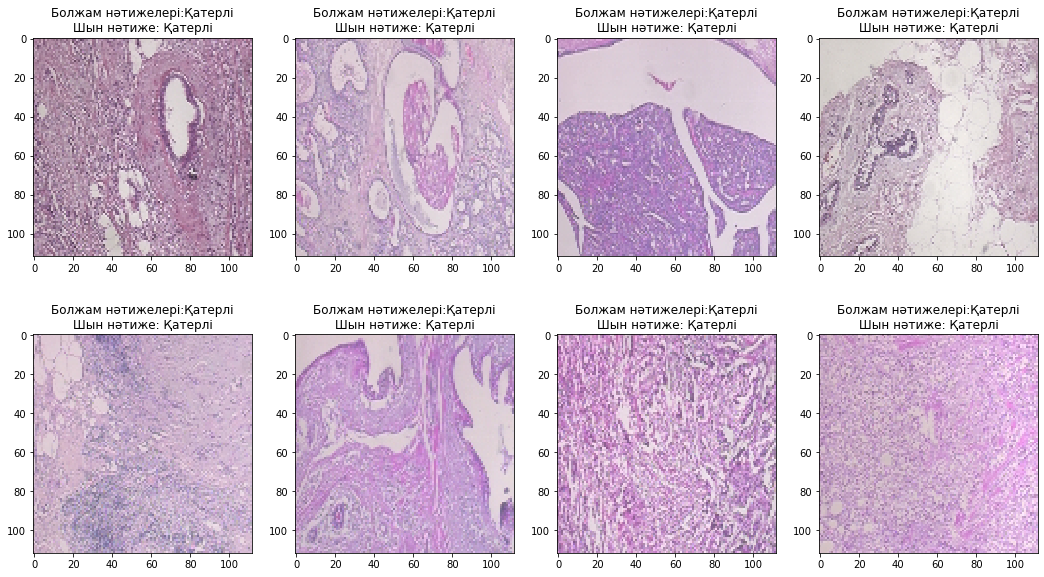

In [31]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Алғашқы 8 суретті көрсету
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Қатерсіз"
    else:
        return "Қатерлі"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Болжам нәтижелері:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Шын нәтиже: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()